## POS Tagging, HMMs, Viterbi

Let's learn how to do POS tagging by Viterbi Heuristic using tagged Treebank corpus. Before going through the code, let's first understand the pseudo-code for the same. 

1. Tagged Treebank corpus is available (Sample data to training and test data set)
   - Basic text and structure exploration
2. Creating HMM model on the tagged data set.
   - Calculating Emission Probabaility: P(observation|state)
   - Calculating Transition Probability: P(state2|state1)
3. Developing algorithm for Viterbi Heuristic
4. Checking accuracy on the test data set


## 1. Exploring Treebank Tagged Corpus

In [2]:
#Importing libraries
import nltk, re
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [3]:
# reading the Treebank tagged sentences
wsj = list(nltk.corpus.treebank.tagged_sents())

In [4]:
# first few tagged sentences
print(wsj[:40])

[[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')], [('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'NNP'), ('publishing', 'VBG'), ('group', 'NN'), ('.', '.')], [('Rudolph', 'NNP'), ('Agnew', 'NNP'), (',', ','), ('55', 'CD'), ('years', 'NNS'), ('old', 'JJ'), ('and', 'CC'), ('former', 'JJ'), ('chairman', 'NN'), ('of', 'IN'), ('Consolidated', 'NNP'), ('Gold', 'NNP'), ('Fields', 'NNP'), ('PLC', 'NNP'), (',', ','), ('was', 'VBD'), ('named', 'VBN'), ('*-1', '-NONE-'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('of', 'IN'), ('this', 'DT'), ('British', 'JJ'), ('industrial', 'JJ'), ('conglomerate', 'NN'), ('.', '.')], [('A', 'DT'), ('f

In [5]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(wsj,test_size=0.3)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

2739
1175
[[('NEC', 'NNP'), ('released', 'VBD'), ('a', 'DT'), ('statement', 'NN'), ('saying', 'VBG'), (',', ','), ('``', '``'), ('We', 'PRP'), ('feel', 'VBP'), ('sorry', 'JJ'), ('for', 'IN'), ('*-1', '-NONE-'), ('having', 'VBG'), ('caused', 'VBN'), ('trouble', 'NN'), ('to', 'TO'), ('society', 'NN'), (',', ','), ("''", "''"), ('a', 'DT'), ('form', 'NN'), ('of', 'IN'), ('apology', 'NN'), ('common', 'JJ'), ('in', 'IN'), ('Japan', 'NNP'), ('for', 'IN'), ('companies', 'NNS'), ('caught', 'VBN'), ('*', '-NONE-'), ('in', 'IN'), ('embarrassing', 'JJ'), ('situations', 'NNS'), ('.', '.')], [('It', 'PRP'), ('is', 'VBZ'), ('not', 'RB'), ('supported', 'VBN'), ('by', 'IN'), ('the', 'DT'), ('text', 'NN'), ('or', 'CC'), ('history', 'NN'), ('of', 'IN'), ('the', 'DT'), ('Constitution', 'NNP'), ('.', '.')], [('Some', 'DT'), ('analysts', 'NNS'), ('are', 'VBP'), ('worried', 'VBN'), ('that', 'IN'), ('reports', 'NNS'), ('of', 'IN'), ('the', 'DT'), ('grain', 'NN'), ('industry', 'NN'), ("'s", 'POS'), ('problems

In [6]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

69941

In [7]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
print(len(tokens))
tokens[:10]

69941


['NEC',
 'released',
 'a',
 'statement',
 'saying',
 ',',
 '``',
 'We',
 'feel',
 'sorry']

In [8]:
# vocabulary
V = set(tokens)
print(len(V))

10173


In [9]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

46

In [10]:
print(T)

{'WP', ':', 'NNS', '``', 'JJ', '-NONE-', 'PDT', 'TO', 'CD', '$', 'EX', 'VBZ', ',', 'RB', 'VBD', 'MD', 'CC', 'PRP$', 'LS', 'SYM', 'VB', 'NNP', 'POS', 'WP$', 'IN', 'RBR', 'NN', 'VBP', 'JJS', 'VBG', 'WRB', 'FW', 'VBN', 'NNPS', '-LRB-', '-RRB-', 'DT', 'WDT', 'JJR', 'UH', 'RBS', '#', '.', 'PRP', 'RP', "''"}


## 2. POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


### Emission Probabilities

In [11]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [12]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [13]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'JJ'))
print(word_given_tag('large', 'VB'))
print(word_given_tag('large', 'NN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'MD'))
print(word_given_tag('will', 'NN'))
print(word_given_tag('will', 'VB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NN'))
print(word_given_tag('book', 'VB'))


 large
(23, 3996)
(0, 1793)
(0, 9131) 


 will
(188, 656)
(1, 9131)
(0, 1793)

 book
(5, 9131)
(1, 1793)


### Transition Probabilities

In [14]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [15]:
# examples
print(t2_given_t1(t2='NNP', t1='JJ'))
print(t2_given_t1('NN', 'JJ'))
print(t2_given_t1('NN', 'DT'))
print(t2_given_t1('NNP', 'VB'))
print(t2_given_t1(',', 'NNP'))
print(t2_given_t1('PRP', 'PRP'))
print(t2_given_t1('VBG', 'NNP'))

(136, 3996)
(1797, 3996)
(2673, 5628)
(59, 1793)
(994, 6620)
(0, 1196)
(5, 6620)


In [16]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DT', '.'))
print(t2_given_t1('VBG', '.'))
print(t2_given_t1('NN', '.'))
print(t2_given_t1('NNP', '.'))


(547, 2704)
(11, 2704)
(118, 2704)
(513, 2704)


In [22]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

CPU times: user 1min 12s, sys: 720 ms, total: 1min 13s
Wall time: 1min 14s


In [35]:
tags_matrix

array([[0.        , 0.        , 0.00632911, ..., 0.06329114, 0.        ,
        0.        ],
       [0.01550388, 0.        , 0.03875969, ..., 0.03100775, 0.        ,
        0.        ],
       [0.00832937, 0.01761066, 0.01118515, ..., 0.00166587, 0.00047596,
        0.00404569],
       ...,
       [0.00167224, 0.00334448, 0.00083612, ..., 0.        , 0.00334448,
        0.        ],
       [0.        , 0.        , 0.06081081, ..., 0.        , 0.        ,
        0.00675676],
       [0.        , 0.00215517, 0.03448276, ..., 0.09698276, 0.        ,
        0.01077586]], dtype=float32)

In [36]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [45]:
tags_df

,WP,:,NNS,``,JJ,-NONE-,PDT,TO,CD,$,...,DT,WDT,JJR,UH,RBS,#,.,PRP,RP,''
WP,0.000000,0.000000,0.006329,0.000000,0.006329,0.772152,0.006329,0.000000,0.000000,0.000000,...,0.044304,0.000000,0.000000,0.000000,0.006329,0.000000,0.000000,0.063291,0.000000,0.000000
:,0.015504,0.000000,0.038760,0.043928,0.072351,0.023256,0.000000,0.002584,0.080103,0.010336,...,0.126615,0.005168,0.005168,0.000000,0.000000,0.000000,0.012920,0.031008,0.000000,0.000000
NNS,0.008329,0.017611,0.011185,0.001904,0.017135,0.039029,0.000000,0.020228,0.001666,0.000714,...,0.013089,0.011185,0.002618,0.000000,0.000000,0.000000,0.123513,0.001666,0.000476,0.004046
``,0.010593,0.000000,0.036017,0.000000,0.116525,0.033898,0.000000,0.000000,0.002119,0.000000,...,0.163136,0.000000,0.000000,0.002119,0.000000,0.000000,0.000000,0.201271,0.000000,0.000000
JJ,0.000250,0.003003,0.240490,0.001502,0.065816,0.022272,0.000000,0.009510,0.020771,0.001251,...,0.004004,0.000000,0.000501,0.000000,0.000000,0.000000,0.023524,0.000501,0.000250,0.005005
-NONE-,0.000000,0.007175,0.006088,0.002392,0.015003,0.074364,0.000000,0.182431,0.002174,0.002609,...,0.056969,0.000217,0.001957,0.000000,0.000217,0.000000,0.094151,0.053055,0.001087,0.000435
PDT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TO,0.000000,0.000000,0.030962,0.004611,0.024374,0.005270,0.000000,0.000000,0.074440,0.038208,...,0.133729,0.000000,0.005270,0.000000,0.000000,0.003294,0.000000,0.005929,0.000000,0.000000
CD,0.000401,0.005620,0.147330,0.000401,0.032517,0.215576,0.000000,0.024488,0.187475,0.000000,...,0.000803,0.001606,0.000803,0.000000,0.000000,0.000000,0.049378,0.000000,0.000000,0.000401
$,0.000000,0.000000,0.000000,0.000000,0.009709,0.000000,0.000000,0.000000,0.990291,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
tags_df.loc['.', :]

JJ        0.033555
NNP       0.186947
CD        0.008481
JJS       0.001844
FW        0.000000
MD        0.000000
-RRB-     0.004056
VBP       0.000000
NNPS      0.002581
VBZ       0.001475
WDT       0.000737
PRP$      0.005162
VBG       0.004056
NNS       0.045723
VBN       0.001106
-LRB-     0.003319
SYM       0.000000
``        0.066003
$         0.001106
#         0.000000
-NONE-    0.022861
RB        0.046091
POS       0.000000
RBS       0.000369
WP$       0.000000
UH        0.000000
''        0.057153
PDT       0.001106
IN        0.118363
:         0.001844
TO        0.001475
WP        0.002212
,         0.000000
.         0.000000
EX        0.004056
VBD       0.000737
JJR       0.001106
RBR       0.000369
VB        0.000000
CC        0.050147
PRP       0.057522
LS        0.001844
NN        0.040929
DT        0.220133
WRB       0.005531
RP        0.000000
Name: ., dtype: float32

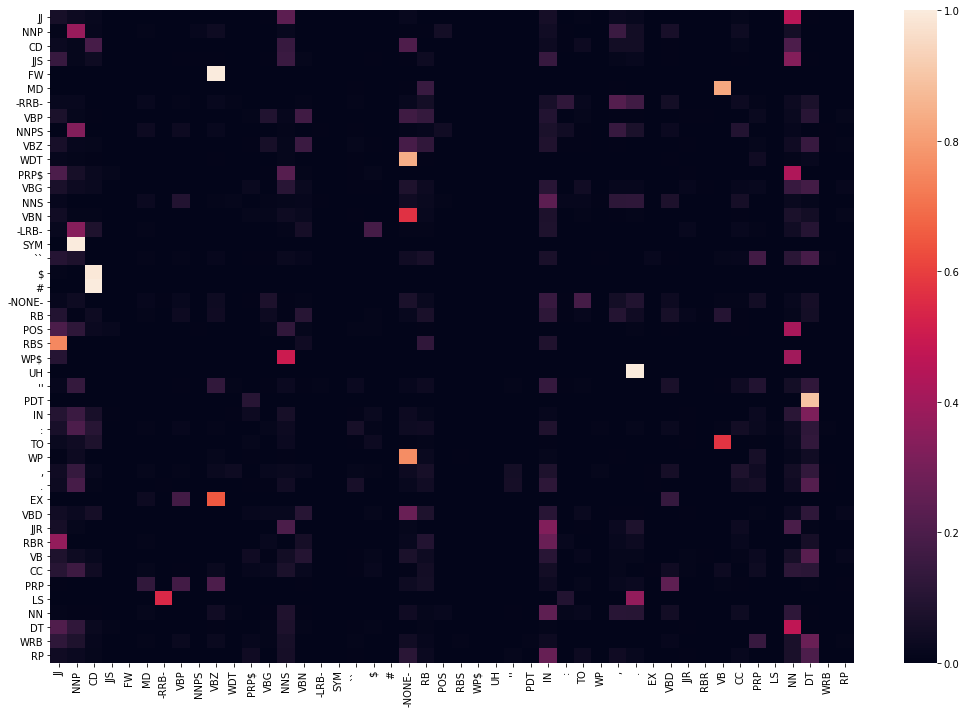

In [35]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


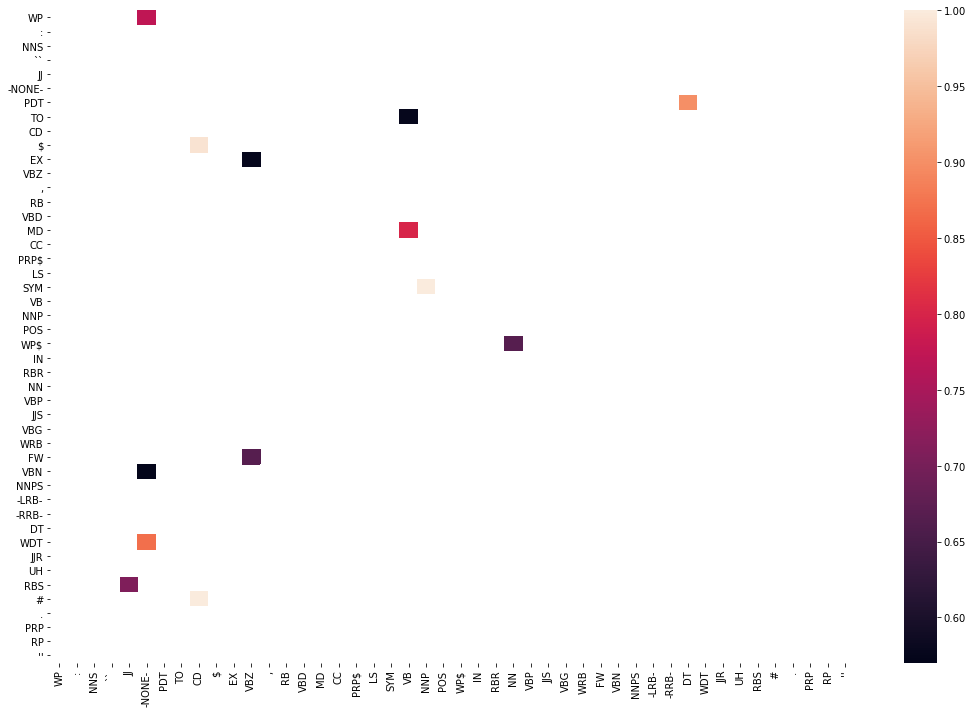

In [46]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## 3. Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [47]:
len(train_tagged_words)

69941

In [48]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



## 4. Evaluating on Test Set

In [43]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Individuals', 'NNS'),
  ('familiar', 'JJ'),
  ('with', 'IN'),
  ('the', 'DT'),
  ('Justice', 'NNP'),
  ('Department', 'NNP'),
  ("'s", 'POS'),
  ('policy', 'NN'),
  ('said', 'VBD'),
  ('that', 'IN'),
  ('Justice', 'JJ'),
  ('officials', 'NNS'),
  ('had', 'VBD'),
  ("n't", 'RB'),
  ('any', 'DT'),
  ('knowledge', 'NN'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('IRS', 'NNP'),
  ("'s", 'POS'),
  ('actions', 'NNS'),
  ('in', 'IN'),
  ('the', 'DT'),
  ('last', 'JJ'),
  ('week', 'NN'),
  ('.', '.')],
 [('In', 'IN'),
  ('her', 'PRP$'),
  ('wake', 'NN'),
  ('she', 'PRP'),
  ('left', 'VBD'),
  ('the', 'DT'),
  ('bitterness', 'NN'),
  ('and', 'CC'),
  ('anger', 'NN'),
  ('of', 'IN'),
  ('a', 'DT'),
  ('principal', 'NN'),
  ('who', 'WP'),
  ('*T*-81', '-NONE-'),
  ('was', 'VBD'),
  ('her', 'PRP$'),
  ('friend', 'NN'),
  ('and', 'CC'),
  ('now', 'RB'),
  ('calls', 'VBZ'),
  ('her', 'PRP'),
  ('a', 'DT'),
  ('betrayer', 'NN'),
  (';', ':'),
  ('of', 'IN'),
  ('colleagues', 'NNS'),
  ('who', 'WP'),
  

In [61]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [62]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  122.65850806236267
[('Individuals', 'JJ'), ('familiar', 'JJ'), ('with', 'IN'), ('the', 'DT'), ('Justice', 'NNP'), ('Department', 'NNP'), ("'s", 'POS'), ('policy', 'NN'), ('said', 'VBD'), ('that', 'IN'), ('Justice', 'NNP'), ('officials', 'NNS'), ('had', 'VBD'), ("n't", 'RB'), ('any', 'DT'), ('knowledge', 'NN'), ('of', 'IN'), ('the', 'DT'), ('IRS', 'NNP'), ("'s", 'POS'), ('actions', 'NNS'), ('in', 'IN'), ('the', 'DT'), ('last', 'JJ'), ('week', 'NN'), ('.', '.'), ('In', 'IN'), ('her', 'PRP$'), ('wake', 'NN'), ('she', 'PRP'), ('left', 'VBD'), ('the', 'DT'), ('bitterness', 'JJ'), ('and', 'CC'), ('anger', 'JJ'), ('of', 'IN'), ('a', 'DT'), ('principal', 'NN'), ('who', 'WP'), ('*T*-81', 'JJ'), ('was', 'VBD'), ('her', 'PRP$'), ('friend', 'JJ'), ('and', 'CC'), ('now', 'RB'), ('calls', 'VBZ'), ('her', 'PRP$'), ('a', 'JJ'), ('betrayer', 'JJ'), (';', ':'), ('of', 'IN'), ('colleagues', 'NNS'), ('who', 'WP'), ('*T*-82', 'JJ'), ('say', 'VBP'), ('0', '-NONE-'), ('she', 'PRP'), (

In [64]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [65]:
accuracy = len(check)/len(tagged_seq)

In [66]:
accuracy

0.8736263736263736

In [67]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [68]:
incorrect_tagged_cases

[[('.', '.'), (('Individuals', 'JJ'), ('Individuals', 'NNS'))],
 [('that', 'IN'), (('Justice', 'NNP'), ('Justice', 'JJ'))],
 [('the', 'DT'), (('bitterness', 'JJ'), ('bitterness', 'NN'))],
 [('and', 'CC'), (('anger', 'JJ'), ('anger', 'NN'))],
 [('who', 'WP'), (('*T*-81', 'JJ'), ('*T*-81', '-NONE-'))],
 [('her', 'PRP$'), (('friend', 'JJ'), ('friend', 'NN'))],
 [('calls', 'VBZ'), (('her', 'PRP$'), ('her', 'PRP'))],
 [('her', 'PRP'), (('a', 'JJ'), ('a', 'DT'))],
 [('a', 'DT'), (('betrayer', 'JJ'), ('betrayer', 'NN'))],
 [('who', 'WP'), (('*T*-82', 'JJ'), ('*T*-82', '-NONE-'))],
 [('who', 'WP'), (('*T*-83', 'JJ'), ('*T*-83', '-NONE-'))],
 [('*T*-83', '-NONE-'), (('defended', 'JJ'), ('defended', 'VBD'))],
 [('was', 'VBD'), (('treated', 'JJ'), ('treated', 'VBN'))],
 [('of', 'IN'), (('school-district', 'JJ'), ('school-district', 'NN'))],
 [('local', 'JJ'), (('martyr', 'JJ'), ('martyr', 'NN'))],
 [('under', 'IN'), (('cultivation', 'JJ'), ('cultivation', 'NN'))],
 [(',', ','), (('soybeans', 'JJ'

In [69]:
## Testing
sentence_test = 'Twitter is the best networking social site. Man is a social animal. Data science is an emerging field. Data science jobs are high in demand.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [70]:
print(tagged_seq)
print(difference)

[('Twitter', 'JJ'), ('is', 'VBZ'), ('the', 'DT'), ('best', 'JJS'), ('networking', 'NN'), ('social', 'JJ'), ('site', 'JJ'), ('.', '.'), ('Man', 'NNP'), ('is', 'VBZ'), ('a', 'DT'), ('social', 'JJ'), ('animal', 'JJ'), ('.', '.'), ('Data', 'NNP'), ('science', 'NN'), ('is', 'VBZ'), ('an', 'DT'), ('emerging', 'VBG'), ('field', 'NN'), ('.', '.'), ('Data', 'NNP'), ('science', 'NN'), ('jobs', 'NNS'), ('are', 'VBP'), ('high', 'JJ'), ('in', 'IN'), ('demand', 'NN'), ('.', '.')]
19.30107307434082
